In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "model/models--CompVis--stable-diffusion-v1-4"  
pipe = StableDiffusionPipeline.from_pretrained(
    model_dir,
    torch_dtype=torch.float32 if device.type == "cuda" else None
)

pipe.to(device)


vae = pipe.vae
unet = pipe.unet
text_encoder = pipe.text_encoder
tokenizer = pipe.tokenizer


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])


class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_paths = [
            os.path.join(image_folder, fname)
            for fname in os.listdir(image_folder)
            if fname.lower().endswith((".jpg", ".png"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# 加载图像数据
image_folder = "shuimo"
dataset = ImageDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 定义 Textual Inversion 模型
class TextualInversion(nn.Module):
    def __init__(self, text_encoder, tokenizer, style_name="shuimo"):
        super(TextualInversion, self).__init__()
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.style_name = style_name

        # 使用可训练的参数向量
        hidden_size = text_encoder.config.hidden_size  
        self.style_embedding = nn.Parameter(torch.randn(hidden_size))

    def forward(self, prompts):

        if isinstance(prompts, str):
            prompts = [prompts]
        

        prompts_with_style = [f"A image of {self.style_name} style: {prompt}" for prompt in prompts]
        

        inputs = self.tokenizer(prompts_with_style, return_tensors="pt", padding=True, truncation=True).to(device)
        text_embeddings = self.text_encoder(input_ids=inputs["input_ids"]).last_hidden_state 

        batch_size = text_embeddings.size(0)
        style_embedding = self.style_embedding.unsqueeze(0).unsqueeze(1)  # (1, 1, 768)
        style_embedding = style_embedding.expand(batch_size, text_embeddings.size(1), -1)  

 
        output_with_style = text_embeddings + style_embedding 
        return output_with_style

# 微调函数
def fine_tune_textual_inversion(
    unet, 
    vae, 
    textual_inversion_model, 
    dataloader, 
    total_steps=500,          
    learning_rate=1e-5, 
    ckpt_dir="./checkpoints", 
    print_every=10           
):
    """
    微调 Textual Inversion 模型
    """
    

    os.makedirs(ckpt_dir, exist_ok=True)
    
    optimizer = optim.Adam([textual_inversion_model.style_embedding], lr=learning_rate)
    loss_fn = nn.MSELoss()

    unet.eval()   # 固定 UNet
    vae.eval()    # 固定 VAE
    
    step = 0      # 当前已训练的步数
    epoch = 0     # 记录遍历数据的轮次
    

    while step < total_steps:
        textual_inversion_model.train()
        epoch += 1
        

        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)):
            batch = batch.to(device)

            timesteps = torch.randint(0, 1000, (batch.size(0),), device=device).long()

            with torch.no_grad():
                latents = vae.encode(batch).latent_dist.sample() * 0.18215

            noise = torch.randn_like(latents)
            noisy_latents = latents + noise * torch.sqrt(
                timesteps.float().unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) / 1000
            )

            # 构造文本输入
            prompts = [f"A painting in the katong style {batch_idx}_{i}" for i in range(batch.size(0))]
            text_embeddings = textual_inversion_model(prompts)

            assert text_embeddings.shape[0] == batch.size(0), "text_embeddings 和 batch_size 不匹配"
            assert text_embeddings.shape[-1] == 768, "text_embeddings 最后一维必须是 768"

            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

            loss = loss_fn(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step += 1  # 累加步数

            
            if step % print_every == 0:
                print(f"Step {step}/{total_steps}, Loss: {loss.item():.4f}")


            if step >= 300 and (step - 300) % 50 == 0:
                ckpt_path = os.path.join(ckpt_dir, f"textinv_step_{step}.pt")
                torch.save({
                    "embedding_state_dict": textual_inversion_model.style_embedding.data,
                    "optimizer_state_dict": optimizer.state_dict(),
                    "step": step
                }, ckpt_path)
                print(f"[Checkpoint Saved] step={step} -> {ckpt_path}")

            # 达到或超过总步数后，停止训练
            if step >= total_steps:
                break
        
        # 每轮结束后打印当前状态
        print(f"Epoch {epoch} finished. Current global step = {step}/{total_steps}")
    
    print("Training finished!")

# 创建 Textual Inversion 模型
textual_inversion_model = TextualInversion(text_encoder, tokenizer, style_name="shuimo").to(device)


# 微调模型
fine_tune_textual_inversion(unet, vae, textual_inversion_model, dataloader)




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 10/500, Loss: 0.4202


Step 20/500, Loss: 0.3468
Epoch 1 finished. Current global step = 20/500


Epoch 2:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Step 30/500, Loss: 0.3412


Step 40/500, Loss: 0.3995
Epoch 2 finished. Current global step = 40/500


Epoch 3:  50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

Step 50/500, Loss: 0.3866


Step 60/500, Loss: 0.3926
Epoch 3 finished. Current global step = 60/500


Epoch 4:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 70/500, Loss: 0.3972


Step 80/500, Loss: 0.3705
Epoch 4 finished. Current global step = 80/500


Epoch 5:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 90/500, Loss: 0.3833


Step 100/500, Loss: 0.4176
Epoch 5 finished. Current global step = 100/500


Epoch 6:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Step 110/500, Loss: 0.3506


Step 120/500, Loss: 0.3363
Epoch 6 finished. Current global step = 120/500


Epoch 7:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 130/500, Loss: 0.3528


Step 140/500, Loss: 0.3051
Epoch 7 finished. Current global step = 140/500


Epoch 8:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 150/500, Loss: 0.3546


Step 160/500, Loss: 0.3558
Epoch 8 finished. Current global step = 160/500


Epoch 9:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 170/500, Loss: 0.3243


Step 180/500, Loss: 0.3103
Epoch 9 finished. Current global step = 180/500


Epoch 10:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 190/500, Loss: 0.3685


Step 200/500, Loss: 0.3429
Epoch 10 finished. Current global step = 200/500


Epoch 11:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 210/500, Loss: 0.3644


Step 220/500, Loss: 0.3370
Epoch 11 finished. Current global step = 220/500


Epoch 12:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 230/500, Loss: 0.3528


Step 240/500, Loss: 0.2724
Epoch 12 finished. Current global step = 240/500


Epoch 13:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 250/500, Loss: 0.3553


Step 260/500, Loss: 0.5259
Epoch 13 finished. Current global step = 260/500


Epoch 14:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 270/500, Loss: 0.5364


Step 280/500, Loss: 0.3543
Epoch 14 finished. Current global step = 280/500


Epoch 15:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 290/500, Loss: 0.3546


Step 300/500, Loss: 0.3989
[Checkpoint Saved] step=300 -> ./checkpoints/textinv_step_300.pt
Epoch 15 finished. Current global step = 300/500


Epoch 16:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 310/500, Loss: 0.4188


Step 320/500, Loss: 0.4021
Epoch 16 finished. Current global step = 320/500


Epoch 17:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Step 330/500, Loss: 0.3515


Step 340/500, Loss: 0.4145
Epoch 17 finished. Current global step = 340/500


Epoch 18:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 350/500, Loss: 0.4410
[Checkpoint Saved] step=350 -> ./checkpoints/textinv_step_350.pt


Step 360/500, Loss: 0.3618
Epoch 18 finished. Current global step = 360/500


Epoch 19:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Step 370/500, Loss: 0.4141


Step 380/500, Loss: 0.4079
Epoch 19 finished. Current global step = 380/500


Epoch 20:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 390/500, Loss: 0.3879


Step 400/500, Loss: 0.4162
[Checkpoint Saved] step=400 -> ./checkpoints/textinv_step_400.pt
Epoch 20 finished. Current global step = 400/500


Epoch 21:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Step 410/500, Loss: 0.4875


Step 420/500, Loss: 0.3233
Epoch 21 finished. Current global step = 420/500


Epoch 22:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Step 430/500, Loss: 0.4551


Step 440/500, Loss: 0.4326
Epoch 22 finished. Current global step = 440/500


Epoch 23:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Step 450/500, Loss: 0.3403
[Checkpoint Saved] step=450 -> ./checkpoints/textinv_step_450.pt


Step 460/500, Loss: 0.3469
Epoch 23 finished. Current global step = 460/500


Epoch 24:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Step 470/500, Loss: 0.4269


Step 480/500, Loss: 0.3594
Epoch 24 finished. Current global step = 480/500


Epoch 25:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Step 490/500, Loss: 0.4043


Step 500/500, Loss: 0.3344
[Checkpoint Saved] step=500 -> ./checkpoints/textinv_step_500.pt
Epoch 25 finished. Current global step = 500/500
Training finished!


  0%|          | 0/50 [00:00<?, ?it/s]

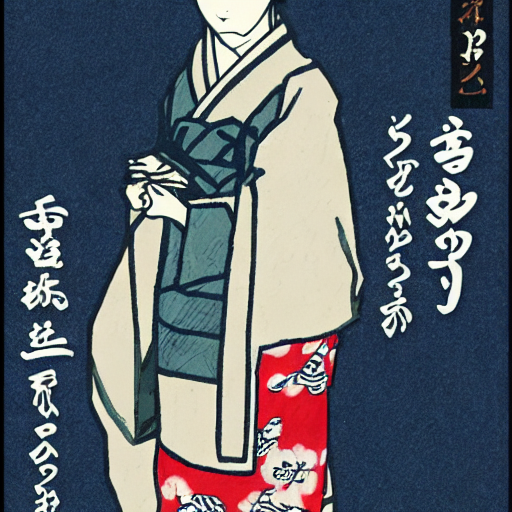

In [2]:
from PIL import Image
from torchvision import transforms
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer

def generate_image(textual_inversion_model, pipe, style_prompt, guidance_scale=7.5, num_inference_steps=50):
    """
    使用微调后的模型生成指定风格的图像
    Args:
        textual_inversion_model: 微调后的文本反演模型
        pipe: 已加载的Stable Diffusion管道
        style_prompt: 你想生成的风格描述
        guidance_scale: 影响生成图像与文本描述一致性的系数，通常在7.5左右
        num_inference_steps: 图像生成的步数，步数越多生成的图像质量通常越高，但也会增加计算开销
    Returns:
        生成的图像（PIL对象）
    """
    
    # 使用微调后的模型获取文本嵌入
    text_embeddings = textual_inversion_model([style_prompt])
    
    pipe.unet.eval()
    pipe.text_encoder.eval()
    pipe.vae.eval()
    
    with torch.no_grad():

        images = pipe(prompt=style_prompt, 
                      num_inference_steps=num_inference_steps, 
                      guidance_scale=guidance_scale,

                      ).images
    
    return images[0]

style_prompt = " a image in shuimo style"
generated_image = generate_image(textual_inversion_model, pipe, style_prompt)

generated_image.show()

generated_image.save("generated_image.png")

Loaded content_image type: <class 'PIL.Image.Image'>


  0%|          | 0/50 [00:00<?, ?it/s]

Generated images type: <class 'list'>
Generated image type: <class 'PIL.Image.Image'>


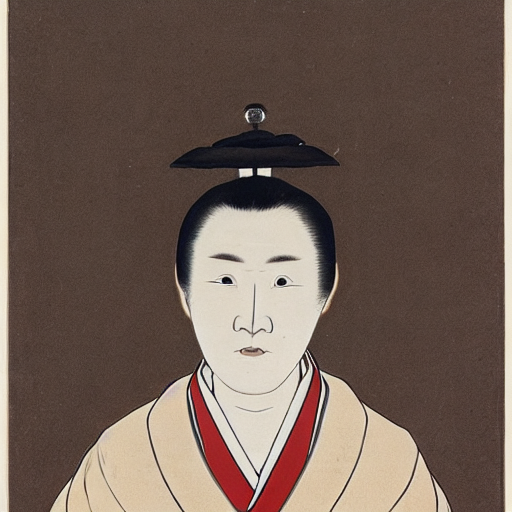

In [3]:
from PIL import Image
import torch
from diffusers import StableDiffusionPipeline

def generate_styled_image(pipe, content_image_path, style_prompt, 
                         guidance_scale=7.5, num_inference_steps=50, strength=0.8):
    """
    使用微调后的模型将指定风格应用到内容图像上。

    Args:
        pipe (StableDiffusionPipeline): 已加载并微调的Stable Diffusion管道。
        content_image_path (str): 内容图像的文件路径。
        style_prompt (str): 风格描述（应包含微调过程中引入的新token，例如"<C1>"）。
        guidance_scale (float, optional): 控制生成图像与文本描述一致性的系数。默认值为7.5。
        num_inference_steps (int, optional): 图像生成的步数。默认值为50。
        strength (float, optional): 内容图像的保留程度，介于0.0到1.0之间。默认值为0.8。

    Returns:
        PIL.Image.Image: 生成的图像对象。
    """
    
    # 使用微调后的模型获取文本嵌入
    text_embeddings = textual_inversion_model([style_prompt])
    pipe.unet.eval()
    pipe.text_encoder.eval()
    pipe.vae.eval()
    
    # 加载内容图像并确保其为PIL.Image.Image对象
    try:
        content_image = Image.open(content_image_path).convert("RGB")
        print(f"Loaded content_image type: {type(content_image)}")  
    except Exception as e:
        raise ValueError(f"Failed to load image from {content_image_path}: {e}")
   
    
    # 使用管道的img2img方法进行风格迁移
    with torch.no_grad():
        try:
            result = pipe(
                prompt=style_prompt, 
                init_image=content_image,
                strength=strength,
                num_inference_steps=num_inference_steps, 
                guidance_scale=guidance_scale,
            )
            images = result.images
            print(f"Generated images type: {type(images)}")  
            print(f"Generated image type: {type(images[0])}")  
        except Exception as e:
            raise ValueError(f"Error during image generation: {e}")
    
    return images[0]

    

content_image_path = "su/11.jpg"  
style_prompt_transfer = "A shuimo style portrait of the person in the image"  

styled_image = generate_styled_image(
    pipe=pipe, 
    content_image_path=content_image_path, 
    style_prompt=style_prompt_transfer,
    guidance_scale=7.5,
    num_inference_steps=50,
    strength=0.75  
)


styled_image.show()


styled_image.save("styled_image.png")